# LuxonisDatasetFormat - testing embeddings methods

In [11]:
import os
import uuid

import numpy as np
import onnx
import onnxruntime
import torch
import torch.onnx
import torchvision
from matplotlib import pyplot as plt
from qdrant_client.models import Distance
from utils.data_utils import load_mnist_data

# only for local testing
import sys
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append('/home/paperspace/Luxonis/luxonis-ml')

from luxonis_ml.data import (
    LuxonisDataset,
    LuxonisLoader,
)
from luxonis_ml.utils import LuxonisFileSystem
from luxonis_ml.embeddings.utils.embedding import (
    extract_embeddings,
    extract_embeddings_onnx,
    extract_embeddings_onnx_LFS,
    load_embeddings,
    save_embeddings,
)
from luxonis_ml.embeddings.utils.ldf import generate_embeddings
from luxonis_ml.embeddings.utils.model import (
    export_model_onnx,
    extend_output_onnx,
    load_model,
    load_model_onnx,
    load_model_resnet50_minuslastlayer,
)
from luxonis_ml.embeddings.utils.qdrant import QdrantAPI, QdrantManager

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytorch examples

In [12]:
# Load the data
data_loader = load_mnist_data(save_path="./mnist", num_samples=640, batch_size=64)

In [13]:
# Load the model
model = load_model_resnet50_minuslastlayer()

In [14]:
# Extract embeddings from the dataset
embeddings, labels = extract_embeddings(model, data_loader)

In [15]:
save_embeddings(embeddings, labels)

## ONNX models and Qdrant

In [16]:
# Load the data
data_loader = load_mnist_data(save_path="./mnist", num_samples=640, batch_size=64)

In [17]:
# Load the model
model = load_model()

# Export the model to ONNX
export_model_onnx(model, model_path_out="resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(
    onnx_model, intermediate_tensor_name="/Flatten_output_0"
)

# Save the ONNX model
onnx.save(onnx_model, "resnet50-1.onnx")

In [18]:
# Create an ONNX Runtime session
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(
    ort_session, data_loader, "/Flatten_output_0"
)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels)

2024-01-30 10:50:29.781348057 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [19]:
embeddings, labels = load_embeddings()

In [20]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container2").start_docker_qdrant()

Container is already running.


In [21]:
# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333, "mnist111")

In [22]:
# Create a collection
vector_size = embeddings.shape[1]
qdrant_api.create_collection(vector_size=vector_size, distance="cosine")

Created new collection


/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/httpx/_content.py:204: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


In [23]:
# Insert the embeddings into the collection
ids = [str(uuid.uuid5(uuid.NAMESPACE_DNS, str(e))) for e in embeddings]
qdrant_api.insert_embeddings(ids, embeddings.tolist(), labels.tolist(), batch_size=50)

In [24]:
# Search for the nearest neighbors
ids, scores = qdrant_api.search_similar_embeddings(embeddings[0], top_k=5)
labels = qdrant_api.retrieve_labels_by_ids(ids)

for i, (id, score, label) in enumerate(zip(ids, scores, labels)):
    print(f"ID: {id}, Score: {score}, Label: {label}")

ID: 65160b65-172c-57bb-acfc-d3e9fe4b7e08, Score: 1.0, Label: 7
ID: 2cf025ea-23b5-5805-a3fb-3b9b1146ec47, Score: 0.9624465, Label: 7
ID: 94c49f1b-263d-5cf3-904f-8fa1cbd53df6, Score: 0.9616008, Label: 7
ID: d8d2ced0-5b8c-5dd3-ba1d-24109b23cdaa, Score: 0.96121967, Label: 7
ID: ea159fc3-8508-5040-9489-6f1068cd36ed, Score: 0.9583215, Label: 7


## LuxonisDatasetFormat, ONNX and Qdrant

In [25]:
NUM_SAMPLES = 6400  # -1 # minus one is equivalent to all samples
BATCH_SIZE = 64

In [26]:
# Load the MNIST data
data_loader = load_mnist_data(
    save_path="./mnist", num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE
)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")

Number of samples: 6400


In [27]:
# Create a tmp directory to store the images
mnist_image_dir = "./mnist_images"
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)

In [28]:
# Convert MNIST data to Luxonis ML format
def mnist_LDF_generator():
    batch_num = 0
    for batch in data_loader:
        images, labels = batch
        for i, (image, label) in enumerate(zip(images, labels)):
            # img_ix = batch_num * BATCH_SIZE + i

            # Save image to disk
            image_path = os.path.join(mnist_image_dir, f"{uuid.uuid4()}.jpg")
            # image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
            torchvision.utils.save_image(image, image_path)

            # Create dictionary structure for Luxonis ML
            yield {
                "file": image_path,
                "class": str(label.item()),
                "type": "classification",
                "value": True,
            }
        batch_num += 1


In [29]:
# 2. Load the MNIST Data into LDF
dataset_name = "mnist_dataset24"

# Create a new dataset in LDF
dataset = LuxonisDataset(dataset_name)

In [30]:
# Add the MNIST data to the dataset
dataset.set_classes(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
dataset.add(mnist_LDF_generator)
dataset.make_splits()

100%|██████████| 6400/6400 [00:00<00:00, 18793.50it/s]


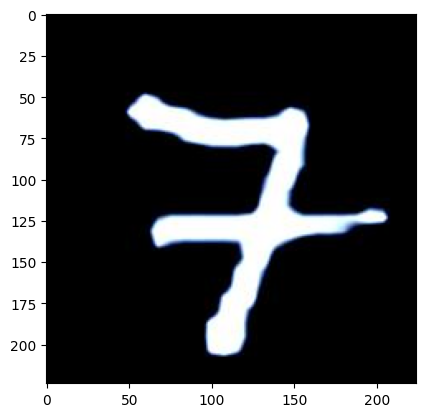

In [31]:
loader = LuxonisLoader(dataset)
for img, _ in loader:
    plt.imshow(img)
    plt.show()
    break

In [32]:
# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

2024-01-30 10:50:56.134729134 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [33]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container2").start_docker_qdrant()

# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333, "mnist23")

# Create a collection
qdrant_api.create_collection(vector_size=2048, distance="cosine")

Container is already running.
Created new collection


/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/httpx/_content.py:204: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


In [34]:
# Load the LuxonisDataset
emb_dict = generate_embeddings(
    dataset, ort_session, qdrant_api, output_layer_name="/Flatten_output_0"
)

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/httpx/_content.py:204: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


Upserted 6400 of embeddings to VectorDB.
Embeddings generation and insertion completed!


In [44]:
first_emb = None

# get a specific sample from dataset
first_sample = list(emb_dict.keys())[0]
first_emb = emb_dict[first_sample]
sample_id = first_sample

df = dataset._load_df_offline()
sample = df[df["file"] == sample_id+".jpg"]
sample

,file,class,type,value,instance_id,value_type,created_at
0,19914adf-055e-4142-9bfc-051dadd49e77.jpg,7,classification,True,30c018f1-2e14-553e-8146-8492158a44a2,bool,2024-01-30 10:50:55.524350


In [36]:
# Search for the nearest neighbors
ids, scores = qdrant_api.search_similar_embeddings(first_emb, top_k=5)
labels = qdrant_api.retrieve_labels_by_ids(ids)

for i, (id, score, label) in enumerate(zip(ids, scores, labels)):
    print(f"ID: {id}, Score: {score}, Label: {label}")

ID: 19914adf-055e-4142-9bfc-051dadd49e77, Score: 1.0, Label: 7
ID: 9d160077-fc23-433d-a397-c629c9a7ccdf, Score: 0.96794724, Label: 7
ID: 55932ff4-720b-4db4-9fb1-877b9327b42f, Score: 0.9672191, Label: 7
ID: 03aee3c6-1c2c-46ca-9f2f-5a1c191b91ca, Score: 0.96696913, Label: 7
ID: a558c9c3-47d3-493e-b02d-767f20d3e4ba, Score: 0.96694416, Label: 7


/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/httpx/_content.py:204: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


## Embeddings Processing

In [37]:
# look at the Embeddings_Processing_Example.ipynb for the rest of the code

## Remove everything

In [38]:
# ! rm -rf ./mnist_images
# ! rm -rf ./mnist
# ! rm ./resnet50.onnx
# ! rm ./resnet50-1.onnx
# ! rm ./embeddings.pth
# ! rm ./labels.pth


In [39]:

# # # Stop the Qdrant Docker container
# # stop_docker_qdrant()

# # Delete the Qdrant collection
# qdrant_client.delete_collection(collection_name="mnist2")
# qdrant_client.delete_collection(collection_name="mnist3")

In [40]:
# # Delete the Luxonis ML dataset

# dataset.delete_dataset()